# 1D CNN text classifier

In [1]:
import csv, time, random
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader


In [2]:
random.seed(0)
torch.manual_seed(0)

BATCH_SIZE = 16
MAX_LEN = 256
LEARNING_RATE = 1e-3
EPOCHS = 5

## Dataset

In [3]:
def load_csv_dataset(path):
    texts = []
    labels = []

    with open(path, "r", encoding="utf-8") as f:
        reader = csv.DictReader(f)
        for row in reader:
            texts.append(row["text"])
            labels.append(int(row["label"]))

    return texts, labels

In [4]:
class TextDataset(Dataset):
    def __init__(self, samples, labels, max_len=MAX_LEN):
        self.samples = samples
        self.labels = labels
        self.max_len = max_len

    def encode(self, s):
        # byte encoding, values 0–255
        x = list(s.encode("utf-8"))[:self.max_len]
        # pad with zeros
        pad_len = self.max_len - len(x)
        x = x + [0] * pad_len
        return torch.tensor(x, dtype=torch.long)

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        return self.encode(self.samples[idx]), torch.tensor(self.labels[idx], dtype=torch.float)

train_texts, train_labels = load_csv_dataset("dataset/train_dataset.csv")
train_loader = DataLoader(
    TextDataset(train_texts, train_labels),
    batch_size=BATCH_SIZE,
    shuffle=True
)

val_texts, val_labels = load_csv_dataset("dataset/val_dataset.csv")
val_loader = DataLoader(
    TextDataset(val_texts, val_labels),
    batch_size=BATCH_SIZE,
    shuffle=False
)

## Base model

### Model definition

In [5]:
class CharCNN(nn.Module):
    def __init__(
        self,
        vocab_size,
        embedding_dim=32,
        num_filters=128,
        kernel_sizes=(3, 5, 7),
        dropout=0.2,
        num_classes=1  # binary classification
    ):
        super().__init__()

        # Character embedding layer
        self.embedding = nn.Embedding(vocab_size, embedding_dim, padding_idx=0)

        # Multiple convolution branches
        self.convs = nn.ModuleList([
            nn.Conv1d(
                in_channels=embedding_dim,
                out_channels=num_filters,
                kernel_size=k
            ) for k in kernel_sizes
        ])

        # Final classifier
        self.dropout = nn.Dropout(dropout)
        self.fc = nn.Linear(num_filters * len(kernel_sizes), num_classes)

    def forward(self, x):
        """
        x: (batch_size, seq_len) - tensor of character IDs
        """
        embedded = self.embedding(x)  # (batch, seq, embed)
        embedded = embedded.transpose(1, 2)  # (batch, embed, seq)

        # Apply conv → ReLU → global max pool
        conv_results = []
        for conv in self.convs:
            c = conv(embedded)                 # (batch, filters, seq')
            c = F.relu(c)
            c = F.max_pool1d(c, kernel_size=c.size(2))  # global max pool
            conv_results.append(c.squeeze(2))

        # Concatenate features
        features = torch.cat(conv_results, dim=1)

        out = self.dropout(features)
        out = self.fc(out)

        # Output logits (use BCEWithLogitsLoss)
        return out

### Training

In [18]:
model = CharCNN(vocab_size=256)
criterion = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)

In [19]:
for epoch in range(EPOCHS):
    total_loss = 0
    t0 = time.time()
    for x, y in train_loader:
        optimizer.zero_grad()
        logits = model(x)
        loss = criterion(logits.squeeze(1), y)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

    print(f"Epoch {epoch+1}: time {(time.time()-t0):.2f}s, loss = {total_loss:.4f}")

Epoch 1: time 28.39s, loss = 38.2102
Epoch 2: time 25.46s, loss = 1.0709
Epoch 2: time 25.46s, loss = 1.0709
Epoch 3: time 24.10s, loss = 0.4894
Epoch 3: time 24.10s, loss = 0.4894
Epoch 4: time 24.07s, loss = 0.1238
Epoch 4: time 24.07s, loss = 0.1238
Epoch 5: time 26.89s, loss = 0.0846
Epoch 5: time 26.89s, loss = 0.0846


#### Visualization

In [20]:
print(model)

CharCNN(
  (embedding): Embedding(256, 32, padding_idx=0)
  (convs): ModuleList(
    (0): Conv1d(32, 128, kernel_size=(3,), stride=(1,))
    (1): Conv1d(32, 128, kernel_size=(5,), stride=(1,))
    (2): Conv1d(32, 128, kernel_size=(7,), stride=(1,))
  )
  (dropout): Dropout(p=0.2, inplace=False)
  (fc): Linear(in_features=384, out_features=1, bias=True)
)


### Evaluation

In [9]:
def predict(model, text):
    model.eval()
    x = torch.tensor([c for c in text.encode()][:MAX_LEN] + [0]*(MAX_LEN-len(text)), dtype=torch.long)
    x = x.unsqueeze(0)
    with torch.no_grad():
        p = torch.sigmoid(model(x)).item()
    return p  # close to 1 = real text, close to 0 = random

In [10]:
TP,TN,FP,FN = 0,0,0,0
model.eval()
with torch.no_grad():
    for xs, ys in val_loader:
        logits = model(xs)
        probs = torch.sigmoid(logits.squeeze(1))
        preds = (probs > 0.5).long()
        targets = ys.long()

        TP += int(((preds == 1) & (targets == 1)).sum().item())
        TN += int(((preds == 0) & (targets == 0)).sum().item())
        FP += int(((preds == 1) & (targets == 0)).sum().item())
        FN += int(((preds == 0) & (targets == 1)).sum().item())


accuracy = (TP + TN) / (TP + TN + FP + FN)
precision = TP / (TP + FP) if (TP + FP) > 0 else 0
recall = TP / (TP + FN) if (TP + FN) > 0 else 0
f1_score = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1_score:.4f}")

Accuracy: 1.0000
Precision: 1.0000
Recall: 1.0000
F1 Score: 1.0000


### Inference

In [11]:
print(predict(model, "Tis is a smple of real text (pretty much)."))  # Expected: close to 1
print(predict(model, "akdng lsmehbo sai ownf 1 asfd dmdl"))  # Expected: close to 0

0.9284425973892212
0.004217686131596565


### Reverse engeneering attack

Can we engeneer a random sequence that gets recognized as real?  
Let's start from a random one and make random changes that improve the score

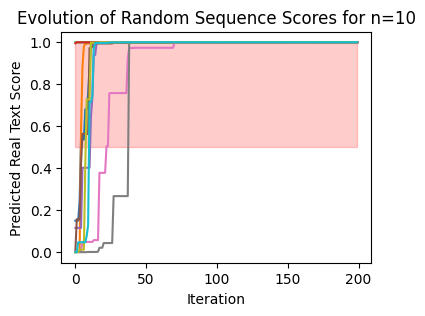

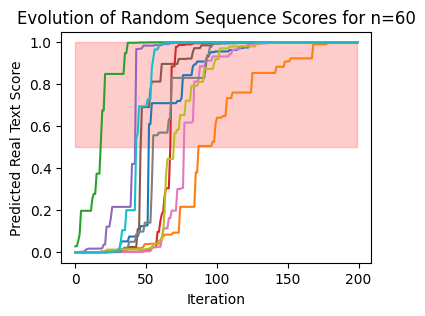

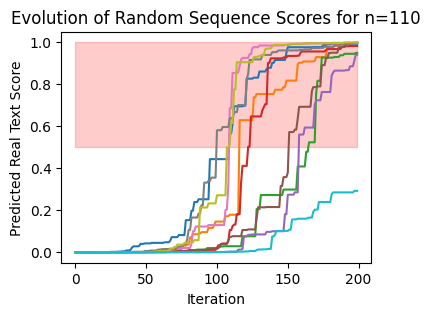

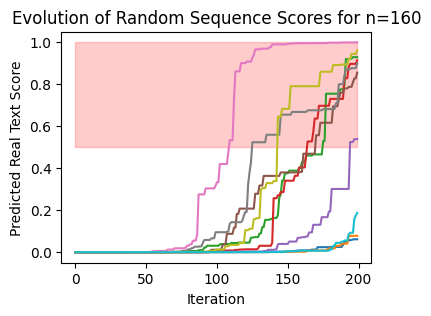

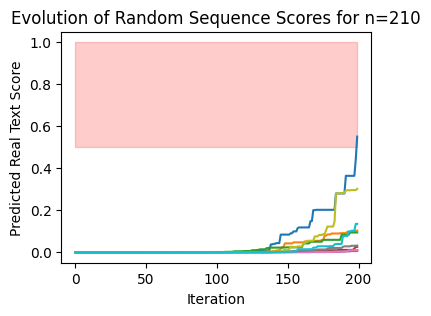

In [12]:
def random_markov_like(n):
    """Produce pseudo-word sequences that look a bit structured but are gibberish."""
    consonants = "bcdfghjklmnpqrstvwxyz "
    vowels = "aeiou "
    s = ""
    for _ in range(n):
        pattern = random.choice([
            random.choice(consonants),
            random.choice(vowels),
            random.choice(consonants) + random.choice(vowels),
            random.choice(vowels) + random.choice(consonants)
        ])
        s += pattern
    return s[:n]

max_ite = 200
# for n in range(10,110,20):
for n in range(10,260,50):
    scores_history = np.zeros((10, max_ite))
    for e in range(10):
        rand_seq = random_markov_like(n)
        score = predict(model, rand_seq)
        # print(f"Initial random sequence: {rand_seq}, score: {score:.4f}")

        for i in range(max_ite):
            chars = "bcdfghjklmnpqrstvwxyz aeiou "
            pos = random.randint(0, len(rand_seq)-1)
            new_char = random.choice(chars)
            new_seq = rand_seq[:pos] + new_char + rand_seq[pos+1:]
            new_score = predict(model, new_seq)
            if new_score > score:
                rand_seq = new_seq
                score = new_score
                # print(f"Iteration {i+1}: Improved sequence: {rand_seq}, score: {score:.4f}")
            scores_history[e, i] = score

    plt.figure(figsize=(4, 3))
    plt.plot(scores_history.T)
    # color the area where the string wolud get recognized as real (0.5 threshold)
    plt.fill_between(range(scores_history.shape[1]), 0.5, 1, color='red', alpha=0.2)
    plt.xlabel("Iteration")
    plt.ylabel("Predicted Real Text Score")
    plt.title(f"Evolution of Random Sequence Scores for n={n}")
    plt.show()

Obtaining a random string that gets classified as real is very easy for short length, a bit more complicated for longer ones:  
this means that the dataset is not good enough or at least that the current model is too weak

Can we use this strategy to generate new sample and retrain the model?   
=> something like boosting

## Second training

Let's try to train for a few more epochs only with samples generated in this way.
In particular we would like to improve the classification of shorter strings.  

If a second training like this will not show its effectiveness, we will build a new model trained with boosting.

In [21]:
def build_epoch_dataset(model, num_samples, seq_len=MAX_LEN, margin=0.1):
    samples = []
    labels = []

    for _ in range(num_samples//2):
        rand_length = random.randint(10, seq_len)
        rand_seq = random_markov_like(rand_length)
        score = predict(model, rand_seq)

        for i in range(200):
            chars = "bcdfghjklmnpqrstvwxyz aeiou "
            pos = random.randint(0, len(rand_seq)-1)
            new_char = random.choice(chars)
            new_seq = rand_seq[:pos] + new_char + rand_seq[pos+1:]
            new_score = predict(model, new_seq)
            if new_score > score:
                rand_seq = new_seq
                score = new_score
            if score > 0.5 + margin:
                break

        samples.append(rand_seq)
        labels.append(0)  # label as random text
        # randomly chose a real text sample from the training data to keep the balance
        samples.append(random.choice(train_texts))
        labels.append(1)

    return samples, labels

def second_training_epoch(model, optimizer, num_samples=200):
    model.train()
    samples, labels = build_epoch_dataset(model, num_samples)
    dataset = TextDataset(samples, labels)
    loader = DataLoader(dataset, batch_size=16, shuffle=True)

    total_loss = 0
    for x, y in loader:
        optimizer.zero_grad()
        logits = model(x)
        loss = criterion(logits.squeeze(1), y)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    return total_loss

In [22]:
for epoch in range(3):
    t0 = time.time()
    loss = second_training_epoch(model, optimizer, num_samples=200)
    print(f"Epoch {epoch+1}: time {(time.time()-t0):.2f}s, loss = {loss:.4f}")

Epoch 1: time 16.66s, loss = 40.5294
Epoch 2: time 6.03s, loss = 9.3408
Epoch 2: time 6.03s, loss = 9.3408
Epoch 3: time 7.28s, loss = 9.7669
Epoch 3: time 7.28s, loss = 9.7669


## Evaluation

Repeat the attack and compare the result

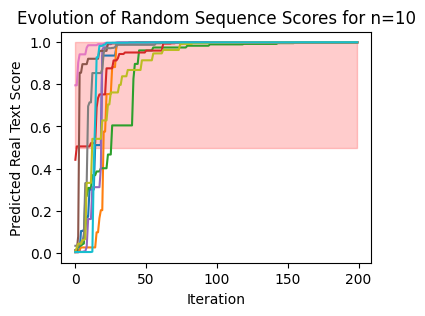

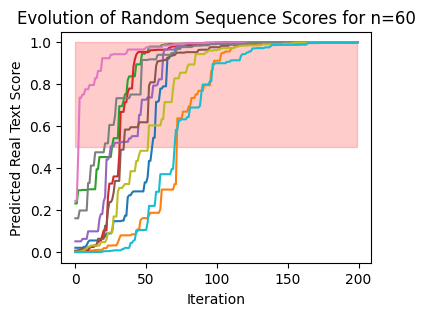

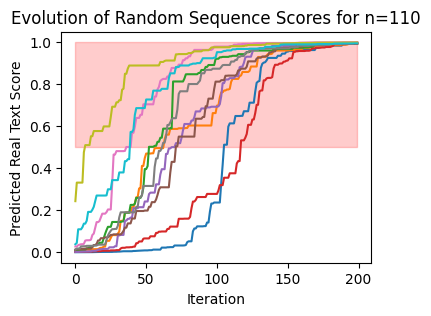

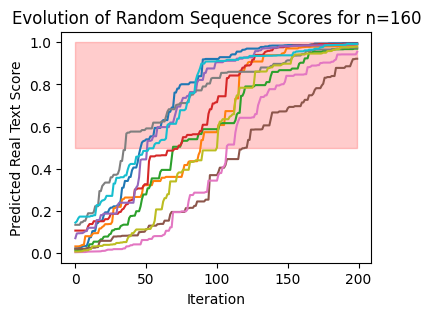

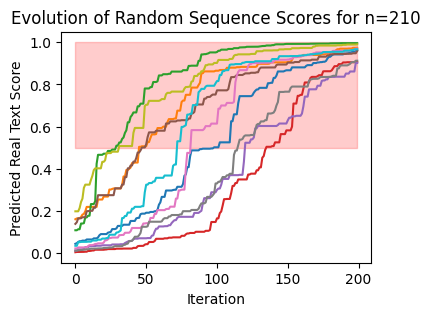

In [23]:
max_ite = 200
# for n in range(10,110,20):
for n in range(10,260,50):
    scores_history = np.zeros((10, max_ite))
    for e in range(10):
        rand_seq = random_markov_like(n)
        score = predict(model, rand_seq)
        # print(f"Initial random sequence: {rand_seq}, score: {score:.4f}")

        for i in range(max_ite):
            chars = "bcdfghjklmnpqrstvwxyz aeiou "
            pos = random.randint(0, len(rand_seq)-1)
            new_char = random.choice(chars)
            new_seq = rand_seq[:pos] + new_char + rand_seq[pos+1:]
            new_score = predict(model, new_seq)
            if new_score > score:
                rand_seq = new_seq
                score = new_score
                # print(f"Iteration {i+1}: Improved sequence: {rand_seq}, score: {score:.4f}")
            scores_history[e, i] = score

    plt.figure(figsize=(4, 3))
    plt.plot(scores_history.T)
    # color the area where the string wolud get recognized as real (0.5 threshold)
    plt.fill_between(range(scores_history.shape[1]), 0.5, 1, color='red', alpha=0.2)
    plt.xlabel("Iteration")
    plt.ylabel("Predicted Real Text Score")
    plt.title(f"Evolution of Random Sequence Scores for n={n}")
    plt.show()

Did the second training affect the overall results?

In [24]:
TP,TN,FP,FN = 0,0,0,0
model.eval()
with torch.no_grad():
    for xs, ys in val_loader:
        logits = model(xs)
        probs = torch.sigmoid(logits.squeeze(1))
        preds = (probs > 0.5).long()
        targets = ys.long()

        TP += int(((preds == 1) & (targets == 1)).sum().item())
        TN += int(((preds == 0) & (targets == 0)).sum().item())
        FP += int(((preds == 1) & (targets == 0)).sum().item())
        FN += int(((preds == 0) & (targets == 1)).sum().item())


accuracy = (TP + TN) / (TP + TN + FP + FN)
precision = TP / (TP + FP) if (TP + FP) > 0 else 0
recall = TP / (TP + FN) if (TP + FN) > 0 else 0
f1_score = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1_score:.4f}")

Accuracy: 0.6235
Precision: 0.5705
Recall: 1.0000
F1 Score: 0.7265
